In [1]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax

from nnp_functions.pf_vehicle import PFVehicle
from nnp_functions.particle_filter import ParticleFilter
from nnp_functions.neural_networks import FeedForwardNetwork



In [2]:
TAU = 1 / (256 * 8 * 60)
KAPPA = 12
X_BAR = jnp.log(0.16)
SIGMA_SIGMA = 6.4
RHO = -0.5

## Stoch Vol Experiments State Space Functions

In [3]:
def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = last_val + TAU * KAPPA * (X_BAR - last_val)
    std = jnp.sqrt(TAU) * SIGMA_SIGMA
    next_val = noise * std + means
    return next_val

def f_sample_fn(subkey, particles, Y_array, idt):
    return f_from_noise(particles, jax.random.normal(subkey, len(particles)))
    

def g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """
    y_means = -0.5 * TAU * jnp.exp(2 * all_particles)
    y_stds = jnp.sqrt(TAU) * jnp.exp(all_particles)
    
    return total_noise * y_stds + y_means

In [4]:
def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = prev_particle + TAU * KAPPA * (X_BAR - prev_particle)  # Mean reversion
    f_std = jnp.sqrt(TAU) * SIGMA_SIGMA  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 

def g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    std = jnp.sqrt(TAU) * jnp.exp(prev_particle)  # full variance
    mean = -0.5 * std**2  # expected mean
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), mean, std)

g_likelihood_weight_fn = jax.vmap(g_likelihood_single, in_axes=(0, 0, None, None))


# Experiments

Investigate how forecasting performance varies with N_particles/ess

In [5]:
TRAIN_KEY = jax.random.key(112)
DATA_KEY = jax.random.key(72)
EVAL_KEY = jax.random.key(81)
INIT_PARTICLE_KEY = jax.random.key(16)

In [6]:
stoch_vol_vehicle = PFVehicle(f_from_noise, g_from_total_noise, f_likelihood_single, g_likelihood_single)

stoch_bootstrap_pf = ParticleFilter(f_sample_fn, g_likelihood_single)

  0%|          | 0/1000 [00:00<?, ?it/s]

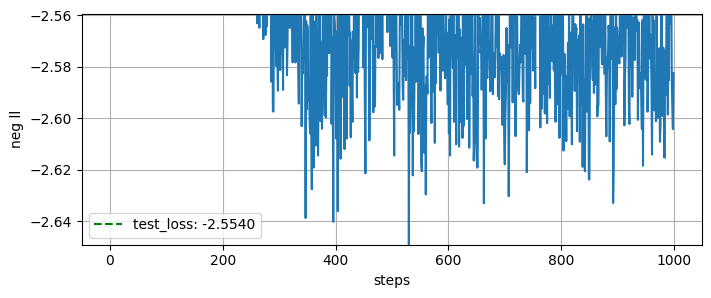

In [7]:
initial_model = FeedForwardNetwork(1, 64, jax.random.key(72))
stoch_vol_vehicle.train_model(
    TRAIN_KEY, 
    initial_model,
    1000, 
    steps = 1000, 
    X_bar = X_BAR
)

# Experiment 1:
## Plotting the Forecasting Evaluations against the Number of particles.

In [35]:
PARTICLE_VALS = [50, 250, 500, 1000, 1500, 2000]
SIMULATE_AT = [0.9]
N_RUNS = 20
N_TIMESTEPS = 1000

In [36]:
All_X, All_Y = stoch_vol_vehicle.generate_data(
    DATA_KEY,
    N_RUNS,
    N_TIMESTEPS,
    starting_point = X_BAR
)

In [37]:
def stack_dicts(dict_list):
    return {
        key: jnp.stack([d[key] for d in dict_list], axis=0)
        for key in dict_list[0]
    }

In [38]:
total_n_forecast_metrics = {}
total_b_forecast_metrics = {}

eval_key = EVAL_KEY

print("Starting particle filter experiments across different particle counts...")
for particle_N in PARTICLE_VALS:
    print(f"\n{'='*60}")
    print(f"Running experiments for particle count: {particle_N}")

    initial_particles = jax.random.normal(INIT_PARTICLE_KEY, (particle_N,)) * 0.1 + X_BAR
    initial_log_weights = jnp.zeros(particle_N) - jnp.log(particle_N)

    print("  - Initializing neural network particle filter...")
    nn_particle_filter = stoch_vol_vehicle.build_NN_particle_filter(N_PARTICLES = particle_N)
    print("  - Initializing bootstrap particle filter...")
    stoch_bootstrap_pf = ParticleFilter(f_sample_fn, g_likelihood_single, N_PARTICLES = particle_N)

    nn_total_forecast_metrics = []
    bootstrap_total_forecast_metrics = []

    take = int(0.9*(N_TIMESTEPS-1))
    
    for run_idx in range(N_RUNS):

        eval_key, key = jax.random.split(eval_key)

        print(f"    > Run {run_idx+1}/{N_RUNS} for particle_N={particle_N} (NN PF)...")
        Y_array, X_array = All_Y[run_idx], All_X[run_idx]

        _, _, nn_forecast_metrics = stoch_vol_vehicle.run_from_particle_filter(
            key, nn_particle_filter, Y_array, X_array, initial_particles,
            simulate_at = SIMULATE_AT,
            tau = TAU,
            n_sample_particles=5000
        )
        print(f"      - Neural network PF diagnostics collected.")

        nn_total_forecast_metrics.append(nn_forecast_metrics[take])

        print(f"    > Run {run_idx+1}/{N_RUNS} for particle_N={particle_N} (Bootstrap PF)...")
        _, _, bootstrap_forecast_metrics = stoch_vol_vehicle.run_from_particle_filter(
            key, stoch_bootstrap_pf, Y_array, X_array, initial_particles,
            simulate_at = SIMULATE_AT,
            tau = TAU, 
            n_sample_particles=5000
        )
        print(f"      - Bootstrap PF diagnostics collected.")

        bootstrap_total_forecast_metrics.append(bootstrap_forecast_metrics[take])

    total_n_forecast_metrics[particle_N] = stack_dicts(nn_total_forecast_metrics)
    total_b_forecast_metrics[particle_N] = stack_dicts(bootstrap_total_forecast_metrics)

print("\nAll particle filter experiments completed successfully.")


Starting particle filter experiments across different particle counts...

Running experiments for particle count: 50
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 6/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 6/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 7/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 7/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 8/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 8/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 9/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 9/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 10/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 10/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 11/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 11/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 12/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 12/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 13/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 13/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 14/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 14/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 15/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 15/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 16/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 16/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 17/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 17/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 18/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 18/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 19/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 19/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 20/20 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 20/20 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.

Running experiments for particle count: 250
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 6/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 6/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 7/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 7/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 8/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 8/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 9/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 9/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 10/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 10/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 11/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 11/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 12/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 12/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 13/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 13/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 14/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 14/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 15/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 15/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 16/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 16/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 17/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 17/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 18/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 18/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 19/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 19/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 20/20 for particle_N=250 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 20/20 for particle_N=250 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.

Running experiments for particle count: 500
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 6/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 6/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 7/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 7/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 8/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 8/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 9/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 9/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 10/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 10/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 11/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 11/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 12/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 12/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 13/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 13/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 14/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 14/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 15/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 15/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 16/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 16/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 17/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 17/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 18/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 18/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 19/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 19/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 20/20 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 20/20 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.

Running experiments for particle count: 1000
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 6/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 6/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 7/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 7/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 8/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 8/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 9/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 9/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 10/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 10/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 11/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 11/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 12/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 12/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 13/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 13/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 14/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 14/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 15/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 15/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 16/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 16/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 17/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 17/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 18/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 18/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 19/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 19/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 20/20 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 20/20 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.

Running experiments for particle count: 1500
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 6/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 6/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 7/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 7/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 8/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 8/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 9/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 9/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 10/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 10/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 11/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 11/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 12/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 12/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 13/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 13/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 14/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 14/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 15/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 15/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 16/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 16/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 17/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 17/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 18/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 18/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 19/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 19/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 20/20 for particle_N=1500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 20/20 for particle_N=1500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.

Running experiments for particle count: 2000
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 2/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 2/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 3/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 3/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 4/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 4/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 5/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 5/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 6/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 6/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 7/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 7/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 8/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 8/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 9/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 9/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 10/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 10/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 11/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 11/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 12/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 12/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 13/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 13/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 14/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 14/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 15/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 15/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 16/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 16/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 17/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 17/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 18/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 18/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 19/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 19/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
    > Run 20/20 for particle_N=2000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 20/20 for particle_N=2000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.

All particle filter experiments completed successfully.


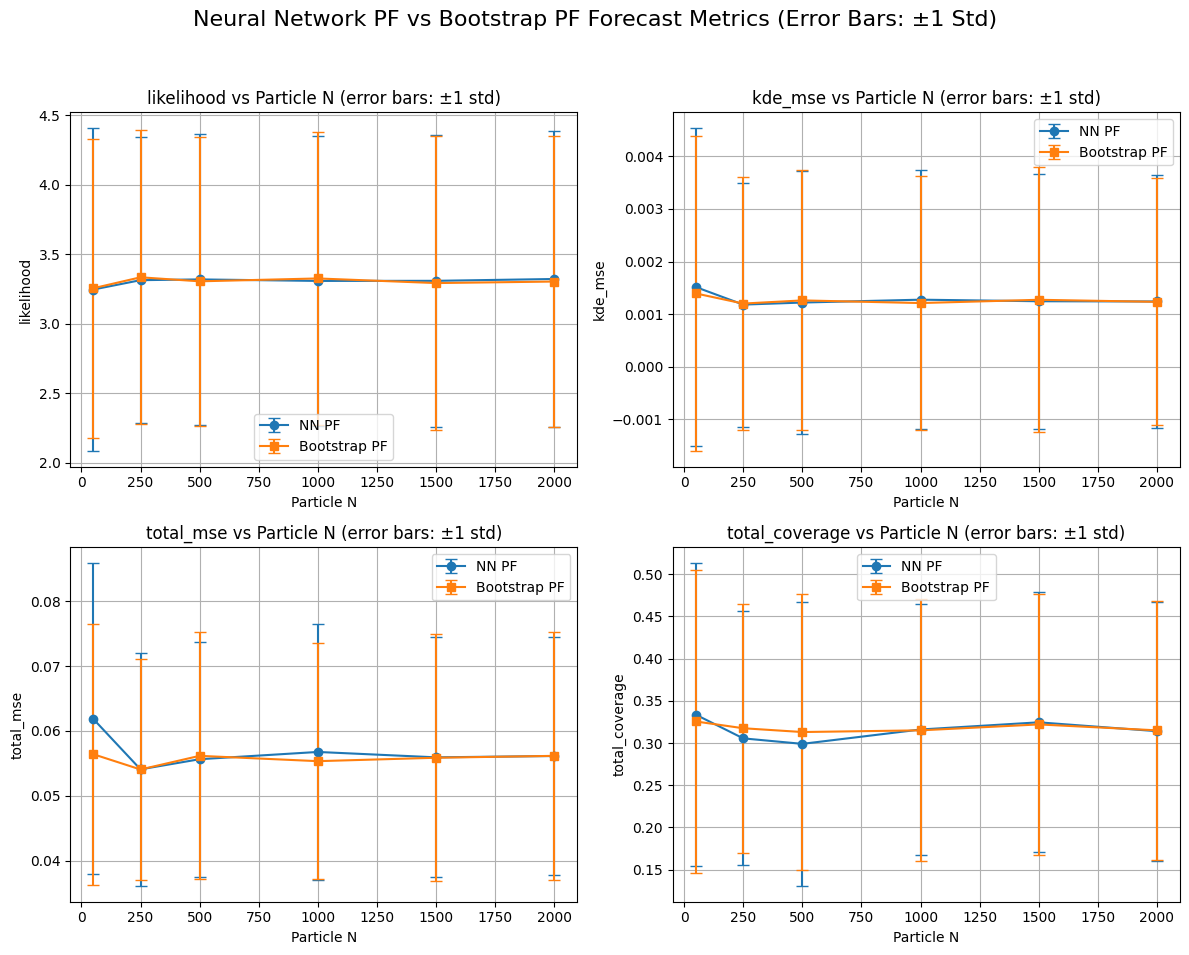

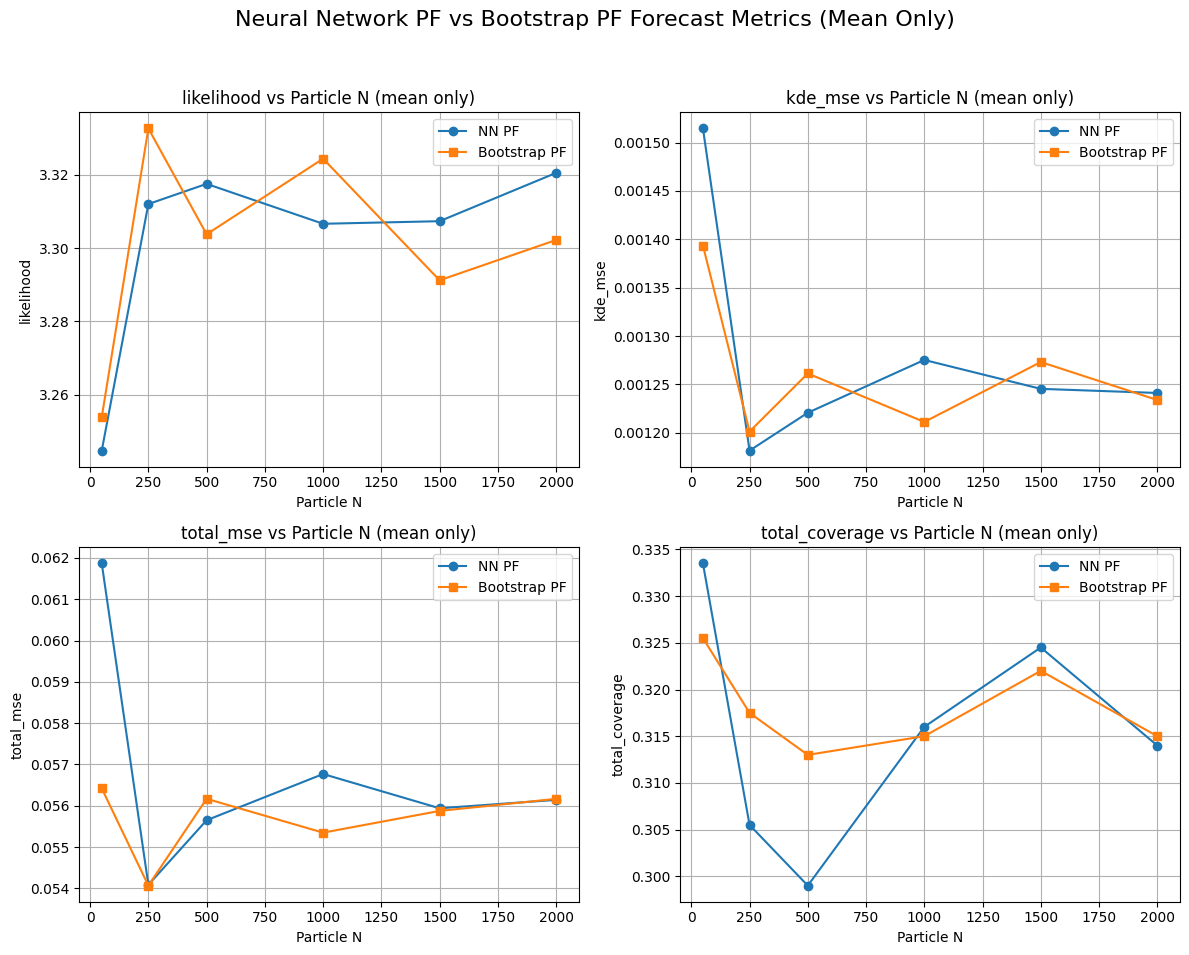

In [46]:
import matplotlib.pyplot as plt

if len(total_n_forecast_metrics) > 0:
    metric_names = list(next(iter(total_n_forecast_metrics.values())).keys())
else:
    metric_names = []

x_keys = sorted(total_n_forecast_metrics.keys())

# Compute means and variances for error bars
def get_mean_and_var(metrics_dict, metric, x_keys):
    means = []
    stds = []
    for k in x_keys:
        vals = metrics_dict[k][metric]
        vals = jnp.asarray(vals)
        means.append(jnp.mean(vals))
        stds.append(jnp.sqrt(jnp.var(vals)))
    return jnp.array(means), jnp.array(stds)

n_metrics = len(metric_names)
n_rows, n_cols = 2, 2

# --- Plot 1: With error bars (±1 std) ---
fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(12, 10))
axes1 = axes1.flatten()

for idx, metric in enumerate(metric_names):
    y_values_nn, y_std_nn = get_mean_and_var(total_n_forecast_metrics, metric, x_keys)
    y_values_boot, y_std_boot = get_mean_and_var(total_b_forecast_metrics, metric, x_keys)
    ax = axes1[idx]
    ax.errorbar(x_keys, y_values_nn, yerr=y_std_nn, marker='o', label='NN PF', capsize=4)
    ax.errorbar(x_keys, y_values_boot, yerr=y_std_boot, marker='s', label='Bootstrap PF', capsize=4)
    ax.set_xlabel("Particle N")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs Particle N (error bars: ±1 std)")
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(idx+1, n_rows*n_cols):
    fig1.delaxes(axes1[j])

fig1.suptitle("Neural Network PF vs Bootstrap PF Forecast Metrics (Error Bars: ±1 Std)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Plot 2: Without error bars ---
fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(12, 10))
axes2 = axes2.flatten()

for idx, metric in enumerate(metric_names):
    y_values_nn, _ = get_mean_and_var(total_n_forecast_metrics, metric, x_keys)
    y_values_boot, _ = get_mean_and_var(total_b_forecast_metrics, metric, x_keys)
    ax = axes2[idx]
    ax.plot(x_keys, y_values_nn, marker='o', label='NN PF')
    ax.plot(x_keys, y_values_boot, marker='s', label='Bootstrap PF')
    ax.set_xlabel("Particle N")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs Particle N (mean only)")
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(idx+1, n_rows*n_cols):
    fig2.delaxes(axes2[j])

fig2.suptitle("Neural Network PF vs Bootstrap PF Forecast Metrics (Mean Only)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


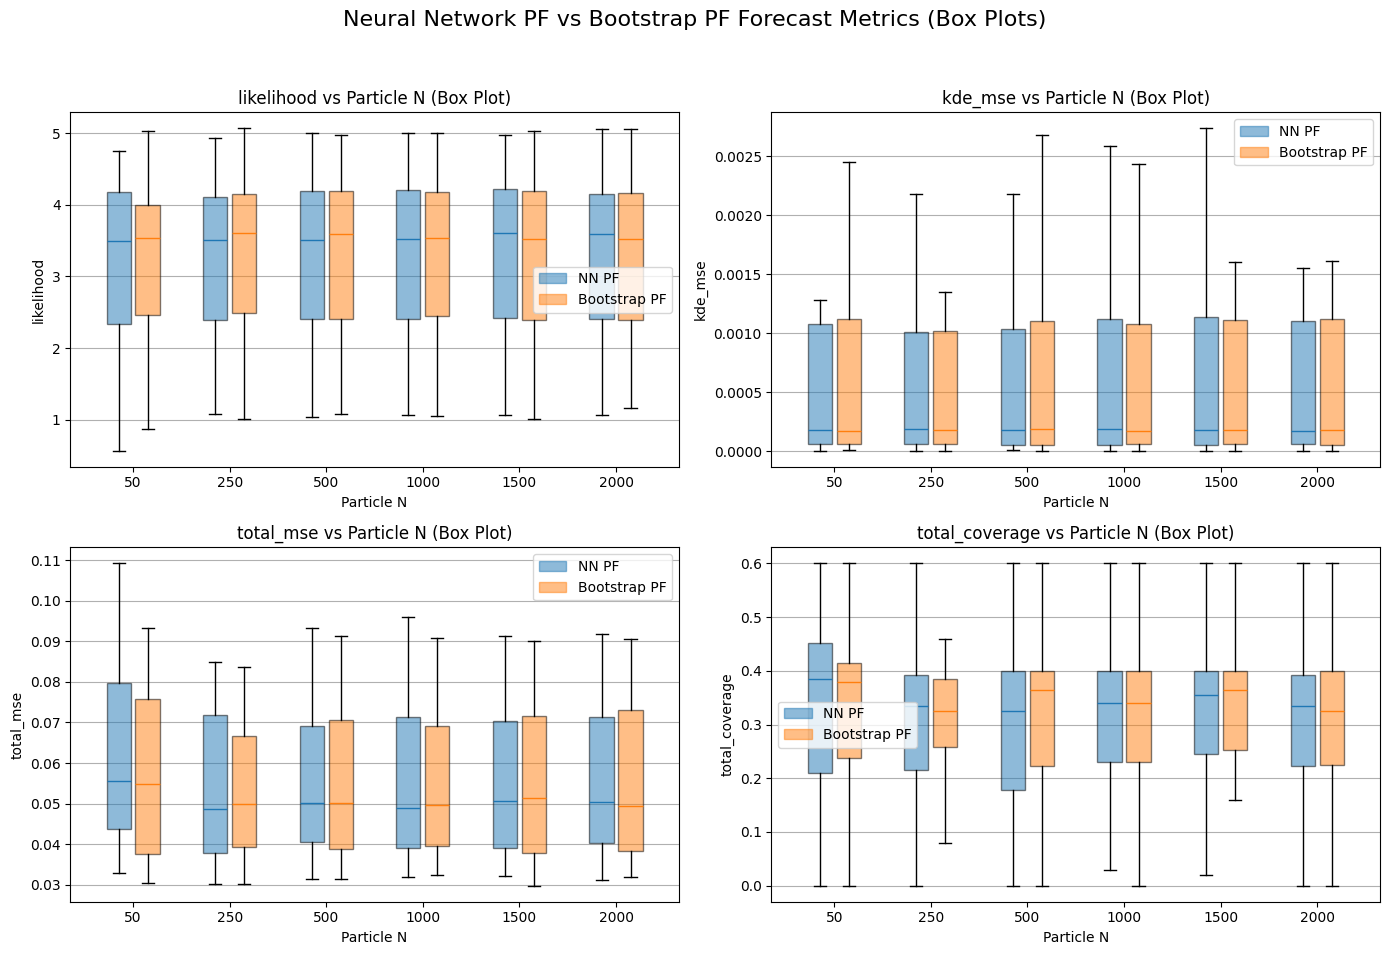

In [48]:
import matplotlib.pyplot as plt

if len(total_n_forecast_metrics) > 0:
    metric_names = list(next(iter(total_n_forecast_metrics.values())).keys())
else:
    metric_names = []

x_keys = sorted(total_n_forecast_metrics.keys())

n_metrics = len(metric_names)
n_rows, n_cols = 2, 2

# --- Plot: Box plots for each metric and method ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(metric_names):
    ax = axes[idx]
    # Collect data for each x_key for both methods
    # Ensure each entry is a 1D array of scalars (not higher-dimensional)
    data_nn = [jnp.asarray(total_n_forecast_metrics[k][metric]).ravel() for k in x_keys]
    data_boot = [jnp.asarray(total_b_forecast_metrics[k][metric]).ravel() for k in x_keys]

    # Positions for boxplots: offset for clarity
    positions_nn = [x - 0.15 for x in range(len(x_keys))]
    positions_boot = [x + 0.15 for x in range(len(x_keys))]

    # Boxplot for NN PF
    bp_nn = ax.boxplot(
        data_nn,
        positions=positions_nn,
        widths=0.25,
        patch_artist=True,
        boxprops=dict(facecolor='C0', alpha=0.5),
        medianprops=dict(color='C0'),
        showfliers=False,
        tick_labels=None  # Use tick_labels instead of labels for matplotlib >=3.9
    )
    # Boxplot for Bootstrap PF
    bp_boot = ax.boxplot(
        data_boot,
        positions=positions_boot,
        widths=0.25,
        patch_artist=True,
        boxprops=dict(facecolor='C1', alpha=0.5),
        medianprops=dict(color='C1'),
        showfliers=False,
        tick_labels=None
    )

    # Set x-ticks and labels
    ax.set_xticks(range(len(x_keys)))
    ax.set_xticklabels([str(x) for x in x_keys])
    ax.set_xlabel("Particle N")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} vs Particle N (Box Plot)")
    ax.grid(True, axis='y')

    # Custom legend
    from matplotlib.patches import Patch
    legend_handles = [
        Patch(facecolor='C0', edgecolor='C0', alpha=0.5, label='NN PF'),
        Patch(facecolor='C1', edgecolor='C1', alpha=0.5, label='Bootstrap PF')
    ]
    ax.legend(handles=legend_handles)

# Hide any unused subplots
for j in range(idx+1, n_rows*n_cols):
    fig.delaxes(axes[j])

fig.suptitle("Neural Network PF vs Bootstrap PF Forecast Metrics (Box Plots)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Experiment 2:
## Investigating the variance of the forecasting metrics. 

In [ ]:
# run all break 
raise ValueError

In [17]:
def var_stack_dicts(dict_list):
    return {
        key: jnp.var(jnp.stack([d[key] for d in dict_list], axis=0))
        for key in dict_list[0]
    }

In [20]:
# Attempting to estimate the variance of the forecasting metrics against the n_samples
var_test_key = jax.random.key(50)
N_sample_vals = [500*x for x in range(1,5)]
N_loops = 10

var_All_X, var_All_Y = stoch_vol_vehicle.generate_data(
    DATA_KEY,
    1,
    5000,
    starting_point = X_BAR
)
var_Y_array, var_X_array = var_All_Y[0], var_All_X[0]


nn_particle_filter = stoch_vol_vehicle.build_NN_particle_filter(N_PARTICLES=2500)
initial_particles = jax.random.normal(INIT_PARTICLE_KEY, (2500,)) * 0.1 + X_BAR
initial_log_weights = jnp.zeros(2500) - jnp.log(2500)

var_result_dict = {}

for sample_val in N_sample_vals:
    result_dict_list = []
    
    for loop_idx in range(N_loops):
        var_test_key, key = jax.random.split(key)

        _, _, nn_forecast_metrics = stoch_vol_vehicle.run_from_particle_filter(
            key, nn_particle_filter, Y_array, X_array, initial_particles,
            simulate_at = SIMULATE_AT,
            tau = TAU,
            n_sample_particles=sample_val
        )

        result_dict = nn_forecast_metrics[int(0.9*(N_TIMESTEPS-1))]
        result_dict_list.append(result_dict)

    var_result_dict[sample_val] = var_stack_dicts(result_dict_list)


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

{500: {'kde_mse': Array(4.7139127e-07, dtype=float32),
       'likelihood': Array(0.00076543, dtype=float32),
       'total_coverage': Array(0.001012, dtype=float32),
       'total_mse': Array(2.0253841e-05, dtype=float32)},
 1000: {'kde_mse': Array(5.436598e-07, dtype=float32),
        'likelihood': Array(0.00059192, dtype=float32),
        'total_coverage': Array(0.000936, dtype=float32),
        'total_mse': Array(1.1026529e-05, dtype=float32)},
 1500: {'kde_mse': Array(4.3538716e-07, dtype=float32),
        'likelihood': Array(0.00062029, dtype=float32),
        'total_coverage': Array(0.00111876, dtype=float32),
        'total_mse': Array(2.0018122e-05, dtype=float32)},
 2000: {'kde_mse': Array(4.1598536e-08, dtype=float32),
        'likelihood': Array(0.00032982, dtype=float32),
        'total_coverage': Array(0.00055936, dtype=float32),
        'total_mse': Array(3.0568913e-06, dtype=float32)}}


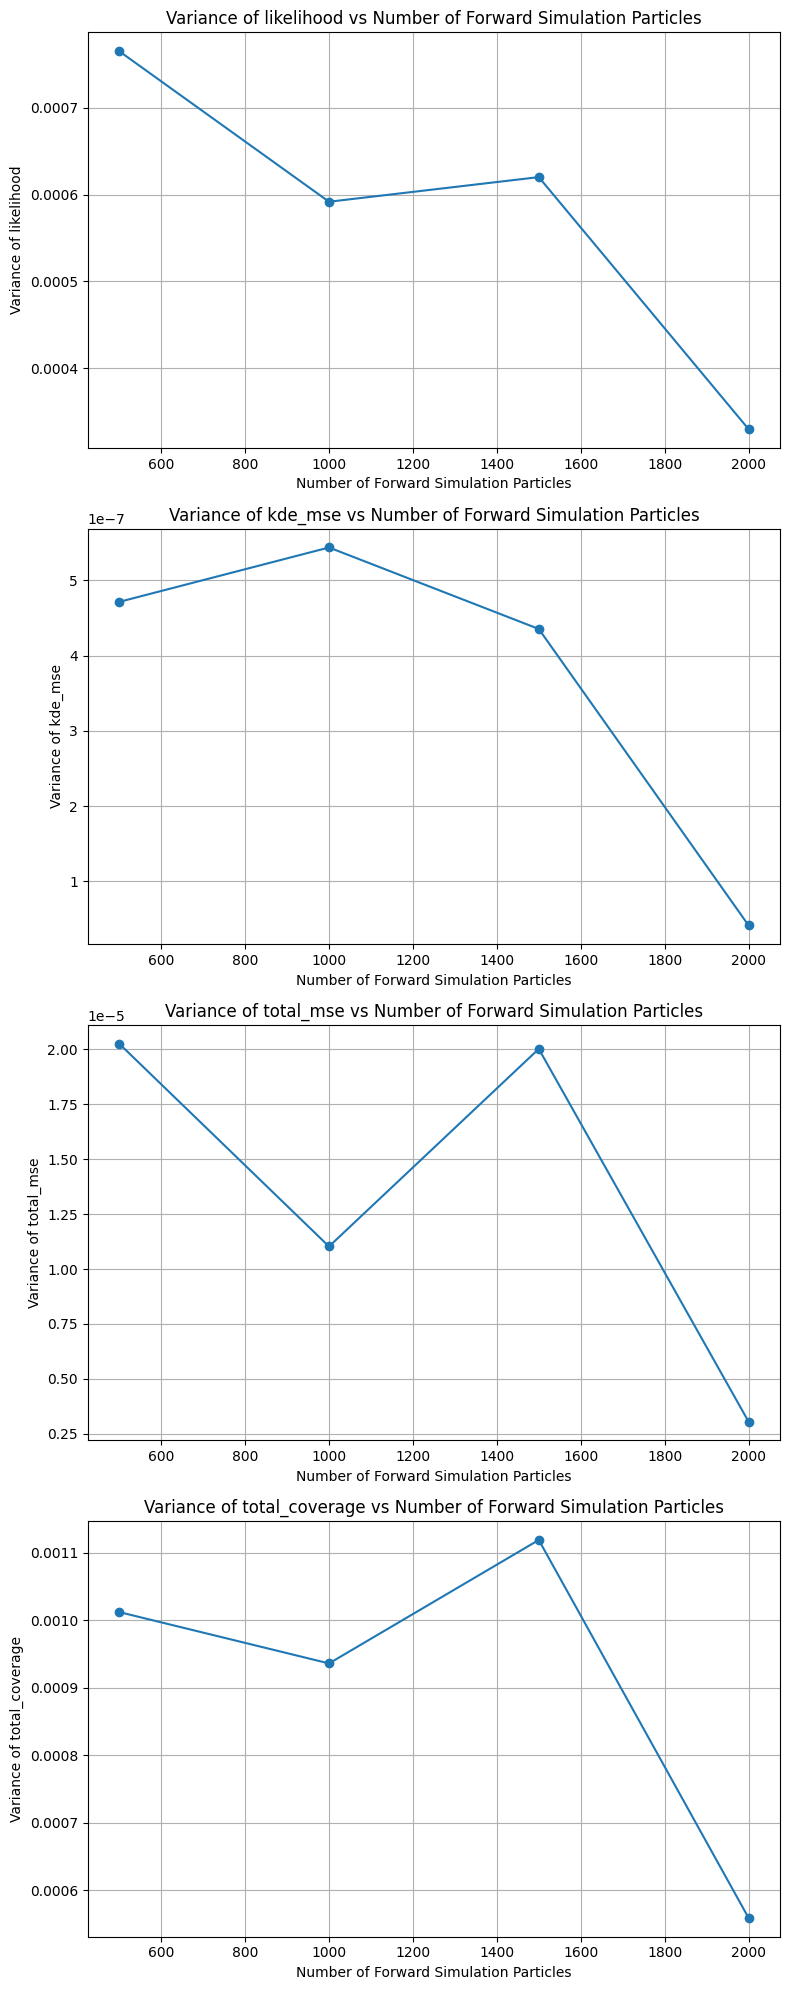

In [ ]:
from pprint import pprint 
import matplotlib.pyplot as plt

# Print the variance results dictionary
pprint(var_result_dict)
# Get metric names from one of the entries in var_result_dict
if len(var_result_dict) > 0:
    # Take the first available sample_val's dict
    first_key = next(iter(var_result_dict))
    metric_names = list(var_result_dict[first_key].keys())
else:
    metric_names = []

x_keys = sorted(var_result_dict.keys())

# Plot all metrics as subplots in a single figure
n_metrics = len(metric_names)
if n_metrics > 0:
    fig, axes = plt.subplots(n_metrics, 1, figsize=(8, 5 * n_metrics), squeeze=False)
    for idx, metric in enumerate(metric_names):
        y_values = [var_result_dict[k][metric] for k in x_keys]
        ax = axes[idx, 0]
        ax.plot(x_keys, y_values, marker='o')
        ax.set_xlabel("Number of Forward Simulation Particles")
        ax.set_ylabel(f"Variance of {metric}")
        ax.set_title(f"Variance of {metric} vs Number of Forward Simulation Particles")
        ax.grid(True)
    plt.tight_layout()
    plt.show()
